<center>


<img src="https://habrastorage.org/webt/jq/gc/r5/jqgcr5azmatev6zvgufn8xftehy.png">
    
#  **II Escuela de Verano en Física Computacional**

##Autores: [Neisser Pino R.](https://scholar.google.com.pe/citations?user=pAB28NEAAAAJ&hl=es), [Ricardo Quispe M.](https://github.com/RcrdPhysics)
##Institución: Universidad Nacional Mayor de San Marcos
##Correo: ricardo.quispe5@unmsm.edu.pe
    
Este material está sujeto a los términos y condiciones de la licencia [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Se permite el uso gratuito para cualquier propósito no comercial.

*También puede consultar la última versión de este notebook en nuestro [repositorio](https://github.com/PCPUNMSM) y los videos de clase [en nuestro canal de Youtube](https://www.youtube.com/channel/UCze8vzQLcplutz0nWDNjFCA).*
    

# <center> Sesión 4. Ecuaciones Diferenciales I
<p align="center">
  <img src="https://forum.openframeworks.cc/uploads/default/973/window_3150.jpg"  width=45% />
</p>

## Outline

1. Simbólico
2. Euler (y ejemplo)
3. Verlet
4. Problema físico


## 1. Cálculo Simbólico

## Máquina de Atwood

La longitud de la cuerda en la polea de radio $R$ estará compuesta por:

$$ x+y+\pi R = l \quad \rightarrow \quad y = -x + \pi R-l$$
Entonces obtenemos:
$$ \dot{y} = - \dot{x} $$

Siendo $x$ e $y$, longitudes de las cuerdas de $m_1$ y $m_2$.

<p align="center">
  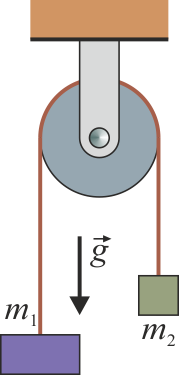
</p>


### Solución simbólica 

Importando librerías:

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import sympy as sym

Estableciendo constantes:

In [ ]:
R,m1,m2,g,L=sym.symbols('R,m_1,m_2,g,L', positive=True)

t=sym.symbols('t')

x=sym.Function('x')
y=-x(t)+ (L-sym.pi*R)

Definiendo energías:

In [ ]:
# Energía cinética (T)
# x.diff(t), y.diff(t) : velocidades
T=sym.Rational(1,2)*m1*x(t).diff(t)**2+ sym.Rational(1,2)*m2*y.diff(t)**2
T#.simplify()

In [ ]:
# Energía potencial (U)

U= -m1*g*x(t) - m2*g*y
U#.simplify()

In [ ]:
Lagr= T-U
Lagr#.simplify()

Obteniendo así el Lagrangiano de la forma: $L(t,x,\dot x) $

**Construimos nuestra ecuación de Euler Lagrange:**

$$ \frac{\partial L}{\partial x} $$

In [ ]:
rhs=Lagr.diff(x(t))
rhs

$$\frac{d}{dt} \left( \frac{\partial L}{\partial \dot x} \right) $$

In [ ]:
lhs= Lagr.diff(x(t).diff(t)).diff(t)
lhs

**Euler-Lagrange equation**:

$$ \frac{d}{dt} \left( \frac{\partial L}{\partial \dot x} \right) - \frac{\partial L}{\partial x} = 0$$

In [ ]:
E_L=sym.Eq(lhs,rhs)
E_L

**Finalmente resolvemos la ecuación diferencial:**

$$\ddot{x}=\frac{g(m_1-m_2)}{(m_1+m_2)}$$

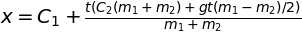

In [ ]:
g_pos = sym.dsolve(E_L) #posición general
g_pos

**Reemplazando valores iniciales**

$$x(0)=0, \qquad \left.\frac{dx}{dt}\right|_0=0$$

In [ ]:
ics={x(0): 0, sym.diff(x(t), t).subs(t,0): 0}

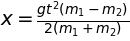

In [ ]:
pos_eq = sym.dsolve(E_L,ics=ics) # reemplazsando condiciones iniciales
pos_eq #ecuación de posición

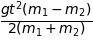

In [ ]:
pos= pos_eq.rhs #solo la parte derecha
pos

**Reemplazando valores numéricos**

$$m_1=10, \quad m_2=5, \quad g=9.8$$

In [ ]:
pos= pos.subs([(g,9.8),(m1,10),(m2,5)])
pos

In [ ]:
vel=pos.diff(t)
vel

In [ ]:
accel= vel.diff(t)
accel

**Simbólico a numérico**

In [ ]:
np_accel=sym.lambdify(t,accel,'numpy') #variable, expresión, librería
np_vel=sym.lambdify(t,vel,'numpy')   
np_pos=sym.lambdify(t,pos,'numpy')

**Solución analítica de posición y velocidad**

Text(0.5, 1.0, 'Máquina de Atwood - m1= 10Kg , m2=5kg, g=9.8')

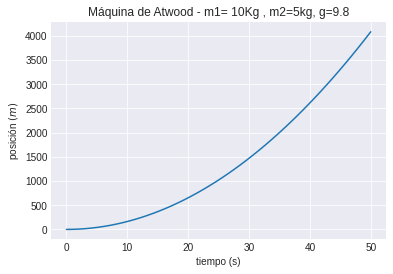

In [ ]:
tt=np.linspace(0,50)
pos_numpy=np_pos(tt)
plt.plot(tt,pos_numpy)

plt.xlabel('tiempo (s)')
plt.ylabel('posición $(m)$')
plt.title('Máquina de Atwood - m1= 10Kg , m2=5kg, g=9.8')


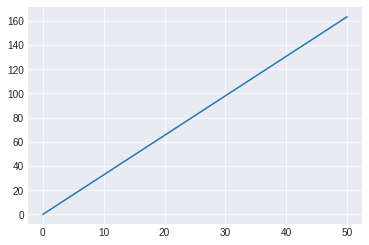

In [ ]:
vel_numpy=np_vel(tt)
plt.plot(tt,vel_numpy)

## 2. Método de Euler

### Problema bien planteado

El problema de valor inicial:

$$\frac{dy}{dt}=f(t,y), \qquad a\leq t\leq b, \qquad y(a)=\alpha,$$

Se dice que es un **problema bien planteado** si:



1.   Existe una única, y(t), y
2.   Existen constante $\epsilon \gt 0$ y $k \gt 0$, tales que para cualquier $\epsilon$ en $(0,\epsilon_0)$, siempre que $\delta(t)$ es continua con $|\delta(t)|\lt \epsilon$ para todo t en $[a,b]$ y cuando $|\delta_0|\lt \epsilon$, el problema de valor inicial

$$\frac{dz}{dt}=f(t,z)+\delta(t), \qquad a \leq t \leq b, \qquad z(a)  =\alpha + \delta_0 $$

tiene una única solución $z(t)$ que satisfac e

$$|z(t)-y(t)|\lt k\epsilon$$

para todo $t$ en $[a,b]$.


### Método

El objetivo del método de Euler es obtener aproximaciones para el problema de valor inicial bien planteado:

$$\frac{dy}{dt}=f(t,y), \qquad a\leq t\leq b, \qquad y(a)=\alpha \qquad \qquad (1)$$


No se obtendrá una aproximación continua a la solución $y(t)$; en su lugar, las aproximaciones se generarán para varios valores llamados **puntos de malla** en el intervalo $[a,b]$.

Una vez que se obtiene la solución aproximada en los puntos, la solución aproximada en otros puntos en el intervalo se puede encontrar a través de interpolación.

primero estipulamos que los puntos de ma ya están Igualmente espaciados a lo largo del intervalo $[a,b]$. Esta copndición se garantiza al seleccionar un entero positivo $N$, al establecer $h=(b-a)/N$, y seleccionar los puntos de malla

$$t_i=a+ih, \qquad i=0,1,2,..,N.$$

Usaremos el teorema de Taylor para deducir el método de Euler para deducir el método de Euler. Suponga que $y(t)$, la única solución, tiene dos derivada continuas en $[a,b]$, de tal forma que cada $i=0,1,2,...,N-1$.

$$y(t_ {i+1})=y(t_i)+(t_{i+1}-t_i)y'(t_i)+\frac{(t_{i+1}-t_i)^2}{2}y''(\xi_i),$$

y ya que $y(t)$ satisface la ecuación (1).

$$y(t_{i+1})=y(t_i)+hf(t_i,y(t_i))+\frac{h^2}{2}y''(\xi_i)$$

El método de Euler es 

$$w_0=\alpha$$

$$w_{i+1}=w_i +hf(t_i,w_i), \qquad i =0,1,...,N-1$$

In [ ]:
def euler(f,x0,xn,y0,n):
    
    h = (xn-x0)/n
    x0_l=[] #lista de pasos
    yn_l=[] #lista de soluciones
    for i in range(n):
        slope = f(x0, y0) #f en datos iniciales 
        yn = y0 + h * slope
        y0 = yn #actualiza el yn (la solución)
        x0 = x0+h #actualiza el paso
        x0_l.append(x0)
        yn_l.append(y0)
    
    return(yn_l) #devuelve la solución numérica para cada n-ésimo paso

### Ley de enfriamiento de Newton

Ley que describe como un objeto con una temperatura inicial  $T(t_0)=T_0$ es enfriado en una temperatura ambiente $T_R$

$$\frac{dT(t)}{dt}=-k\Delta T =-k(T(t)-T_R)$$

$\frac{dT(t)}{dt}$ nos dice la taza de enfriamiento de un objeto es proporcional a la diferencia de temperaturas.

Cuya solución analítica es: 

$$T(t)=T_R+(T(0)-T_R)e^{-kt}$$

Vamos a verificar la solución analítica desde SymPy:

In [ ]:
Tr,t,k,T0 = sym.symbols('T_R, t,k,T_0')
Tt = sym.Function('T')
dTdt = Tt(t).diff(t)
expr2 = sym.Eq(dTdt, -k*(Tt(t)-Tr))
expr2

Eq(Derivative(T(t), t), -k*(-T_R + T(t)))

In [ ]:
sym.dsolve(expr2)

Eq(T(t), C1*exp(-k*t) + T_R)

In [ ]:
ics2={Tt(0): T0}
Eq_sol=sym.dsolve(expr2,ics=ics2) # Igualdad
sol=Eq_sol.rhs #solo la expresión de la solución
sol

T_R + (T_0 - T_R)*exp(-k*t)

Queda demostrado.

In [ ]:
#k=0.07 T_R=20°C
#EDO 
def newtoncooling(time, temp):
	return -0.07 * (temp - 20)
#ANALITICA
def newtoncooling_ana(t,TR=20,T0=100,k=0.07):
  return TR+(T0-TR)*np.exp(-k*t) #TR Temperatura de entorno

In [ ]:
a=0
b=100 #segundos 
N1=10 #datos
N2=100
N3=1000
h1=(a-b)/N1
h2=(a-b)/(N2) 
h3=(a-b)/(N3)
#t_T=np.linspace(a,b,N3) #tiempo para las temperaturas
t_T=np.linspace(a,b,N2)
#t_T=np.linspace(a,b,N1)
#Temp_1= euler(newtoncooling,a,b,100,N1)
Temp_2= euler(newtoncooling,a,b,100,N2)
#Temp_3= euler(newtoncooling,a,b,100,N3)
Temp_ana=newtoncooling_ana(t_T)

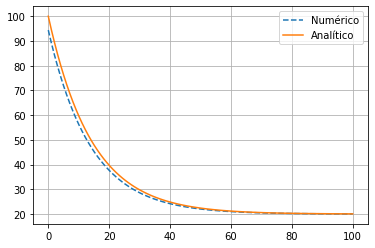

In [ ]:
fig = plt.figure()
#plt.plot(t_T,Temp_1)
plt.plot(t_T,Temp_2, '--')
#plt.plot(t_T,Temp_3)
plt.plot(t_T,Temp_ana)
plt.legend(["Numérico", "Analítico"])

plt.grid()
plt.show() 

## 3. Método de Verlet

##### El problema de valor inicial (de segundo orden):

\begin{equation}
\left\{
	       \begin{array}{ll}
		 y'' = F(y) \\
		 y(0) = \alpha \\
         y'(0) = \beta
	       \end{array}
	     \right.
\end{equation}

##### se discretiza de manera similar al método de Euler y luego se aplica el siguiente algoritmo (*la deducción de este algoritmo se realiza truncando series de Taylor hacia adelante y hacia atras de $F(y)$*):

\begin{equation}
\left\{
	       \begin{array}{ll}
		 y_0 = \alpha \\
		 y_{-1} = y_0 - \beta \Delta x + \frac{1}{2}F(y_0)\Delta x^2 \\
         y_{i+1} = 2 y_i -y_{i-1} + F(y_i)\Delta x^2
	       \end{array}
	     \right.
\end{equation}

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def verlet(f,a,b,xf,niter):
    dx = xf/(niter-1)
    xs = np.arange(0,xf+dx,dx)
    ys = np.zeros(np.size(xs))
    yinit = a-dx*b+0.5*dx*dx*f(a) # paso de arranque
    ys[0] = yinit
    ys[1] = a
    for i in range(1,niter-1):
        ys[i+1] = 2*ys[i]-ys[i-1]+f(ys[i])*pow(dx,2)
    return xs, ys


#### Solución a un problema de caida libre:
##### Se suelta un objeto (inicialmente en reposo) desde una altura de $100$ m.

\begin{equation}
\left\{
	       \begin{array}{ll}
		 y'' = -g \\
		 y(0) = 100 \\
         y'(0) = 0
	       \end{array}
	     \right.
\end{equation}

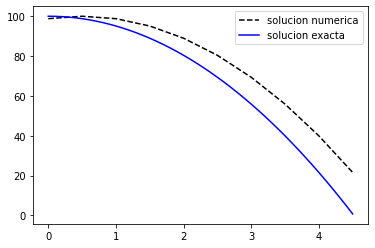

In [ ]:
# Solucion de un problema de caida libre
def f(y):
    return -9.8

pos0 = 4.5
t, y = verlet(f,100.0,0.0,pos0,10)

def sol_ex(t):
    return 100 -9.8/2.0*pow(t,2)

t_ex = np.arange(0.0,pos0+0.1,0.1)
y_ex = np.zeros(np.size(t_ex))
for i in range(np.size(t_ex)):
    y_ex[i] = sol_ex(t_ex[i])

plt.plot(t,y,'k--',label = 'solucion numerica')
plt.plot(t_ex,y_ex,'b',label = 'solucion exacta')
plt.legend()

Solución a un problema oscilador lineal vs no-lineal:

\begin{equation}
\left\{
	       \begin{array}{ll}
		 y'' = -\sin(y) \sim -y \\
		 y(0) = \theta_0 \\
         y'(0) = 0
	       \end{array}
	     \right.
\end{equation}

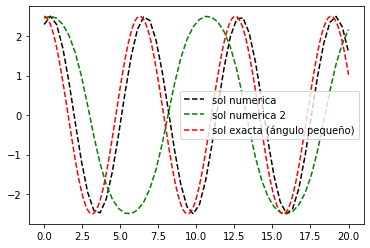

In [ ]:
# solucion de un problema de oscilador lineal vs oscilador no-lineal
def f2(y):
    return -y

def f3(y):
    return -np.sin(y)

tfinal = 20.0
npuntos = 50
# ang_init = 0.5 angulo pequeño \theta_0
ang_init = 2.5
t2, y2 = verlet(f2,ang_init,0.0,tfinal,npuntos)
t3, y3 = verlet(f3,ang_init,0.0,tfinal,npuntos)

t_ex2 = np.arange(0.0,tfinal+0.1,0.1)
y_ex2 = np.zeros(np.size(t_ex2))
for i in range(np.size(t_ex2)):
    y_ex2[i] = ang_init*np.cos(t_ex2[i])

plt.plot(t2,y2,'k--',label='sol numerica')
plt.plot(t3,y3,'g--',label='sol numerica 2')
plt.plot(t_ex2,y_ex2,'r--',label = 'sol exacta (ángulo pequeño)')
plt.legend()
plt.show()

## Problema físico

### Pelota que rebota

En este artículo estamos resolviendo el problema de la pelota que rebota con el integrador más simple de todos: el esquema de Euler hacia adelante.

Tenemos que resolver la *EDO de segundo orden* (ecuaciones de movimiento de Newton con aceleración constante)

$$
\frac{d^2 y}{dt^2} = -g
$$

donde $ g $ es la aceleración constante debida a la gravedad y $ y (t) $ es la posición de la pelota en función del tiempo (su
trayectoria).

El esquema de Euler hacia adelante para cualquier *EDO de primer orden*

$$ \frac{dy}{dt} = f(y, t) $$

es

$$ y(t + h) = y(t) + h f(y(t), t). $$

Para resolver la ecuación de movimiento original de segundo orden, hacemos uso del hecho de que una EDO de $ n $ -ésimo orden puede escribirse como $ n $ EDO acopladas de primer orden, a saber

$$
\begin{align}
\frac{dy}{dt} &= v\\
\frac{dv}{dt} &= -g.
\end{align} $$

Resuelva cada una de las EDO de primer orden con el algoritmo de Euler:

$$
\begin{align}
y(t + h) &= y(t) + h v(t)\\
v(t + h) &= v(t) - h g.
\end{align} $$


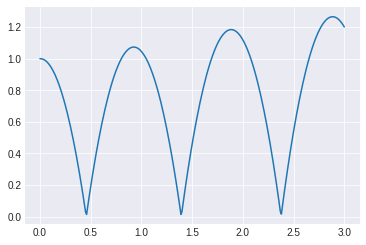

In [ ]:
# Utilice el método de Euler para calcular la trayectoria de un rebote
# bola asumiendo una reflexión perfecta en la superficie x = 0.
# Utilice unidades SI (metros y segundos)

steps = 300     # número de pasos de tiempo calculados
endtime = 3.0   # fin de la simulación
g = 9.8         # gravedad

# crear matrices 1D de pasos de longitud +1 para tiempo (t), posición (x), velocidad (v)

t = zeros(steps+1)
x = zeros(steps+1)
v = zeros(steps+1)

# inicializar variables en el tiempo = 0.0

x[0] = 1.0
v[0] = 0.0
t[0] = 0.0

dt = endtime / float(steps)

for i in range (steps):
   t[i+1] = t[i] + dt
   x[i+1] = x[i] + v[i]*dt
   v[i+1] = v[i] - g*dt
   if x[i+1] < 0.0:    #si la bola está debajo de la superficie, refléjala
      x[i+1] = -x[i+1]
      v[i+1] = -v[i+1]

plt.plot(t, x)
show()


In [ ]:
def bouncingBall(g: 'gravity value of g(m/s2)',
                 y: 'vertical position',
                 v: 'velocity',
                 t: 'time',
                 dt: 'time step',
                 y_floor: 'floor position',
                 e: 'Coefficient of restitution',
                 interval: 'time interval',
                 title: 'name of experiment'):    
   
    data = []
    
    while t < interval:
        y += v*dt
        if y > y_floor:
            v += g*dt
        else:
            v=-e*v # rebotar en el suelo con Coeficiente de restitución - COR
        data.append([t, y, v]) 
        t += dt
    
    data = np.array(data).transpose()
    plt.plot(data[0], data[1])
    plt.title(title)
    plt.xlabel("time (s)")
    plt.ylabel("position (m)")

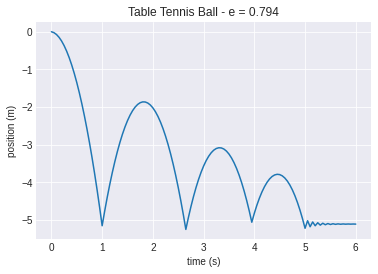

In [ ]:
bouncingBall(-9.81, 0, 0, 0, 0.05, -5, 0.794, 6, "Pelota de tenis de mesa - e = 0.794")

Rango de valores para $e$ (Coeficiente de resitución) - tratado como una constante

$e$ es ser un número real positivo entre 0 y 1:

$e = 0$: esta es una colisión perfectamente inelástica. Esto significa que la energía cinética a lo largo de la normal común es 0. La energía cinética se convierte en calor o en el trabajo realizado para deformar los objetos.

$0 <e <1$: Ésta es una colisión inelástica del mundo real, en la que se disipa algo de energía cinética.

$e = 1$: Se trata de una colisión perfectamente elástica, en la que no se disipa energía cinética y los objetos rebotan entre sí con la misma velocidad relativa con la que se acercaron.

$e <0$: Un COR menor que cero representaría una colisión en la que la velocidad de separación de los objetos tiene la misma dirección (signo) que la velocidad de cierre, lo que implica que los objetos se atraviesan entre sí sin engancharse completamente. Esto también puede considerarse como una transferencia incompleta de impulso. Un ejemplo de esto podría ser un objeto pequeño y denso que atraviesa uno grande y menos denso, por ejemplo, una bala que atraviesa un objetivo, una motocicleta que atraviesa una casa rodante o una ola que atraviesa una presa.

$e> 1$: Esto representaría una colisión en la que se libera energía, por ejemplo, las bolas de billar de nitrocelulosa pueden literalmente explotar en el punto de impacto. Asimismo, algunos artículos recientes han descrito colisiones superelásticas en las que se argumenta que el COR puede tomar un valor superior a uno en un caso especial de colisiones oblicuas456. Estos fenómenos se deben al cambio de trayectoria de rebote provocado por la fricción. En tal colisión, la energía cinética aumenta de manera que la energía se libera en algún tipo de explosión. Es posible que $e = ∞$ para una explosión perfecta de un sistema rígido.

# 7. Resumen

*   SymPy llega a ser una librería bastante eficiente para resolver analíticamente PVI en EDOs, tiene una amplia gamma de funciones y una comunidad científica trabajando en ello
*   El método de Euler es un método sencillo de implementar, pero de bajo orden.
*   Tiene errores cuando la pendiente instantánea cambia rápidamente dentro de la $\Delta x$.
*   El algoritmo de Verlet es particularmente apropiado en las situaciones en que la expresión de la segunda derivada solo es función de las variables, dependiente o independiente, sin participar la primera derivada. Este es el caso de numerosos problemas de la dinámica newtoniana, por lo que se emplea frecuentemente en astronomía y mecánica molecular.

## 8. Recursos útiles
* ["Documentación de SymPy"](https://docs.sympy.org/latest/index.html)
* ["Ejemplos avanzados de SymPy"](https://www.youtube.com/watch?v=r4piIKV4sDw)
* ["Métodos Numéricos con Python"](https://github.com/pachocamacho1990/MetNum_Py)
* ["La bola que rebota"](https://www.kaggle.com/gzstoyanov/the-bouncing-ball)
* ["Algoritmo de Verlet"](https://es.wikipedia.org/wiki/Integración_de_Verlet)
* Eric Ayars , 'Computational Physics with Python" (libro completo [aquí](https://belglas.files.wordpress.com/2018/03/cpwp.pdf))
* ["How to Think Like a Computer Scientist"](https://nbviewer.jupyter.org/github/Yorko/mlcourse.ai/blob/master/jupyter_english/tutorials/merging_dataframes_tutorial_max_palko.ipynb) - Think Python Versión 2.0.17 by Allen Doney. (libro completo [aquí](https://www.greenteapress.com/thinkpython/thinkpython.pdf))
* L. Verlet, Computer experiments on classical fluids. I. Thermodynamical properties of Lennard-Jones molecules, Physical Review 159, 98 (1967)
* Richard L. Burden, 'Analisis Numerico', 10ma Edición


## Donaciones
<br>
<center>
Puedes donar una vez en el siguiente enlace (Ko-Fi):

<br>
    
*Click en la imagen.*

<a href="https://ko-fi.com/rcrdphysics">
<img src="https://habrastorage.org/webt/8r/ml/xf/8rmlxfpdzukegpxa62cxlfvgkqe.png" width=20% />

</center>